In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy to /content/facial_fuse/label-distribution-learning-fer-tf
import shutil
import os
src_dir = '/content/drive/MyDrive/facial_fuse/label-distribution-learning-fer-tf'
dst_dir = '/content/facial_fuse/label-distribution-learning-fer-tf'
os.makedirs(os.path.dirname(dst_dir), exist_ok=True)
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

In [ ]:
%cd /content/facial_fuse/label-distribution-learning-fer-tf

✅ Loaded 10767 training samples and 2706 test samples.


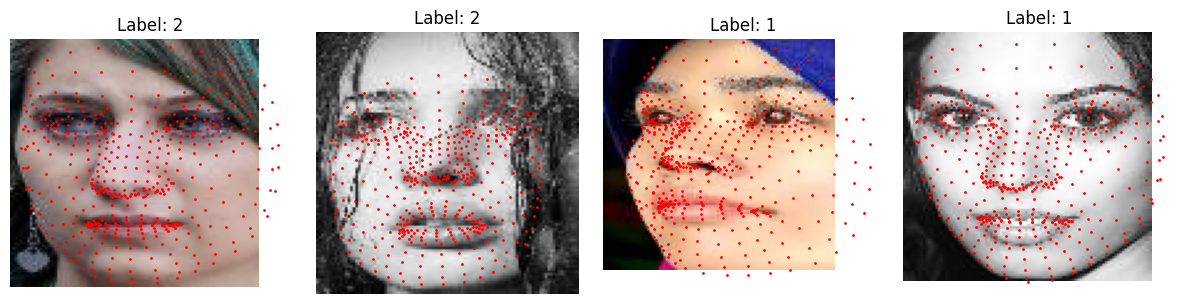

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

base_dir = '/content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb'
aligned_dir = os.path.join(base_dir, 'aligned')
aligned3d_dir = os.path.join(base_dir, 'aligned3D')
df_train = pd.read_csv(os.path.join(base_dir, '3Draf_train.csv'))
df_test = pd.read_csv(os.path.join(base_dir, '3Draf_test.csv'))
df_train = df_train[['subDirectory_filePath', 'expression']]
df_test = df_test[['subDirectory_filePath', 'expression']]
df_train.columns = ['file', 'label']
df_test.columns = ['file', 'label']
def build_data_list(df, split):
    data_list = []
    for _, row in df.iterrows():
        base = os.path.splitext(row['file'])[0]  # e.g., train_00001_aligned
        img_path = os.path.join(aligned_dir, base + '.jpg')
        npy_path = os.path.join(aligned3d_dir, base + '.npy')
        if os.path.exists(img_path) and os.path.exists(npy_path):
            data_list.append({
                'img': img_path,
                'npy': npy_path,
                'label': row['label'],
                'split': split
            })
    return data_list

train_data = build_data_list(df_train, 'train')
test_data = build_data_list(df_test, 'test')

print(f"Loaded {len(train_data)} training samples and {len(test_data)} test samples.")

def preview_samples(data_list, n=4):
    plt.figure(figsize=(n * 3, 3))
    for i in range(min(n, len(data_list))):
        entry = data_list[i]
        img = Image.open(entry['img'])
        landmarks = np.load(entry['npy'])

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        if landmarks.shape[1] >= 2:
            plt.scatter(landmarks[:, 0], landmarks[:, 1], s=1, c='red')
        plt.title(f"Label: {entry['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
preview_samples(train_data, n=4)


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

sample = train_data[0]
img_path = sample['img']
npy_path = sample['npy']
label = sample['label']

img = Image.open(img_path).convert('RGB').resize((112, 112))
img_arr = np.array(img).astype(np.float32)
img_arr = (img_arr - 127.5) / 127.5
img_arr = np.transpose(img_arr, (2, 0, 1))
img_arr = np.expand_dims(img_arr, axis=0)

lmk = np.load(npy_path).astype(np.float32)
lmk_flat = lmk.flatten()  #(478*3,) = (1434,)
lmk_flat = np.expand_dims(lmk_flat, axis=0)

mlp_backbone = tf.keras.models.load_model('/content/facial_fuse/label-distribution-learning-fer-tf/pretrained/mlp_landmark_backbone.h5')
resnet_backbone = tf.keras.models.load_model('/content/facial_fuse/label-distribution-learning-fer-tf/pretrained/resnet50.h5')

lmk_feat = mlp_backbone(lmk_flat)
resnet_feat = resnet_backbone(img_arr)

print(f"Landmark feature shape: {lmk_feat.shape}")
print(f"Image (ResNet) feature shape: {resnet_feat.shape}")

img_vis = np.transpose(img_arr[0], (1, 2, 0))
img_vis = (img_vis * 127.5 + 127.5).astype(np.uint8)

plt.imshow(img_vis)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

sample = train_data[0]
img_path = sample['img']
npy_path = sample['npy']
label = sample['label']

img = Image.open(img_path).convert('RGB').resize((112, 112))
img_arr = np.array(img).astype(np.float32)
img_arr = (img_arr - 127.5) / 127.5
img_arr = np.transpose(img_arr, (2, 0, 1))   #HWCtoCHW
img_arr = np.expand_dims(img_arr, axis=0)    #(1, 3, 112, 112)

lmk = np.load(npy_path).astype(np.float32)
lmk_flat = lmk.flatten()
lmk_flat = np.expand_dims(lmk_flat, axis=0)  # (1, 1434)

mlp_backbone = tf.keras.models.load_model('/content/facial_fuse/label-distribution-learning-fer-tf/pretrained/mlp_landmark_backbone.h5')
resnet_backbone = tf.keras.models.load_model('/content/facial_fuse/label-distribution-learning-fer-tf/pretrained/resnet50.h5')

class LateFusionModel(tf.keras.Model):
    def __init__(self, image_backbone, lmk_backbone, num_classes=7):
        super().__init__()
        self.image_backbone = image_backbone
        self.lmk_backbone = lmk_backbone
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, image_input, landmark_input):
        img_feat = self.image_backbone(image_input)
        lmk_feat = self.lmk_backbone(landmark_input)
        fused = tf.concat([img_feat, lmk_feat], axis=-1)
        return self.classifier(fused)

model = LateFusionModel(resnet_backbone, mlp_backbone)
pred = model(img_arr, lmk_flat)

print("🔮 Softmax Prediction:", pred.numpy())
print("🎯 Predicted class:", np.argmax(pred.numpy()))
print("✅ True label:", label)

img_vis = np.transpose(img_arr[0], (1, 2, 0)) * 127.5 + 127.5
plt.imshow(img_vis.astype(np.uint8))
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
# # resnet alone
# import tensorflow as tf
# import numpy as np
# from PIL import Image

# resnet_backbone.trainable = False

# class ImageOnlyModel(tf.keras.Model):
#     def __init__(self, image_backbone, num_classes=7):
#         super().__init__()
#         self.image_backbone = image_backbone
#         self.classifier = tf.keras.Sequential([
#             tf.keras.layers.Dense(256, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(num_classes, activation='softmax')
#         ])

#     def call(self, image_input):
#         img_feat = self.image_backbone(image_input)
#         return self.classifier(img_feat)

# model = ImageOnlyModel(resnet_backbone)

# def preprocess_image_only(sample):
#     img = Image.open(sample['img']).convert('RGB').resize((112, 112))
#     img_arr = np.array(img).astype(np.float32)
#     img_arr = (img_arr - 127.5) / 127.5
#     img_arr = np.transpose(img_arr, (2, 0, 1))  # (3, 112, 112)
#     label = sample['label']
#     return img_arr, label

# def image_only_generator(data_list):
#     for sample in data_list:
#         img, label = preprocess_image_only(sample)
#         yield img, label

# train_dataset = tf.data.Dataset.from_generator(
#     lambda: image_only_generator(train_data),
#     output_signature=(
#         tf.TensorSpec(shape=(3, 112, 112), dtype=tf.float32),
#         tf.TensorSpec(shape=(), dtype=tf.int32)
#     )
# )

# BATCH_SIZE = 32
# train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# EPOCHS = 10
# model.fit(train_dataset, epochs=EPOCHS)


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tqdm import tqdm

resnet_backbone.trainable = False

class ImageOnlyModel(tf.keras.Model):
    def __init__(self, image_backbone, num_classes=7):
        super().__init__()
        self.image_backbone = image_backbone
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, image_input, training=False):
        img_feat = self.image_backbone(image_input, training=training)
        return self.classifier(img_feat, training=training)

model = ImageOnlyModel(resnet_backbone)

def preprocess_image_only(sample):
    img = Image.open(sample['img']).convert('RGB').resize((112, 112))
    img_arr = np.array(img).astype(np.float32)
    img_arr = (img_arr - 127.5) / 127.5
    img_arr = np.transpose(img_arr, (2, 0, 1))  #(3, 112, 112)
    label = sample['label']
    return img_arr, label

def image_only_generator(data_list):
    for sample in data_list:
        img, label = preprocess_image_only(sample)
        yield img, label

train_dataset = tf.data.Dataset.from_generator(
    lambda: image_only_generator(train_data),
    output_signature=(
        tf.TensorSpec(shape=(3, 112, 112), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_acc.reset_state()
    print(f"\n Epoch {epoch+1}/{EPOCHS}")

    for batch in tqdm(train_dataset):
        images, labels = batch

        with tf.GradientTape() as tape:
            logits = model(images, training=True)
            loss = loss_fn(labels, logits)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss.update_state(loss)
        train_acc.update_state(labels, logits)

    print(f"Loss: {train_loss.result():.4f} | Accuracy: {train_acc.result():.4f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE

test_dataset = tf.data.Dataset.from_generator(
    lambda: image_only_generator(test_data),
    output_signature=(
        tf.TensorSpec(shape=(3, 112, 112), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(32).prefetch(tf.data.AUTOTUNE)

all_preds, all_labels, all_logits, all_features = [], [], [], []

extractor = tf.keras.Model(inputs=model.image_backbone.input, outputs=model.image_backbone.output)

for batch in tqdm(test_dataset, desc="Evaluating"):
    images, labels = batch
    logits = model(images, training=False)
    features = extractor(images, training=False)

    preds = tf.argmax(logits, axis=1)

    all_preds.extend(preds.numpy())
    all_labels.extend(labels.numpy())
    all_logits.extend(logits.numpy())
    all_features.extend(features.numpy())

class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger']
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

acc = accuracy_score(all_labels_np, all_preds_np)
conf_matrix = confusion_matrix(all_labels_np, all_preds_np, labels=np.arange(len(class_names)))
per_class_acc = conf_matrix.diagonal() / np.maximum(conf_matrix.sum(axis=1), 1)

print(f"\n Top-1 Accuracy: {acc:.4f}")
print(" Per-class Accuracy:")
for i, a in enumerate(per_class_acc):
    print(f"  {class_names[i]}: {a:.4f}")

print("\n Classification Report:")
print(classification_report(all_labels_np, all_preds_np, target_names=class_names, digits=4))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.gca().invert_yaxis()
plt.show()

tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(np.array(all_features))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=all_labels_np, cmap='tab10', alpha=0.7)
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Emotions")
plt.title("t-SNE Projection of ResNet Features")
plt.show()


In [29]:
print(model.summary())

Model: "image_only_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ (None, 512)            │    43,590,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,590,976 (166.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 43,590,976 (166.29 MB)

None


In [31]:

# model.save_weights('/content/resnetonly_plain.weights.h5')
# print("Weights saved to 'resnetonly_plain.weights.h5'")
model = ImageOnlyModel(resnet_backbone)
dummy_input = tf.random.normal((1, 3, 112, 112))
_ = model(dummy_input, training=False)
model.load_weights('/content/resnetonly_plain.weights.h5')

In [ ]:

from google.colab import files
files.download("resnetonly_plain.h5")

✅ Model saved as 'resnetonly_plain.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # resnet and 3d, late fusion
# import tensorflow as tf
# import numpy as np
# from PIL import Image

# resnet_backbone.trainable = False
# mlp_backbone.trainable = False

# class LateFusionModel(tf.keras.Model):
#     def __init__(self, image_backbone, lmk_backbone, num_classes=7):
#         super().__init__()
#         self.image_backbone = image_backbone
#         self.lmk_backbone = lmk_backbone
#         self.classifier = tf.keras.Sequential([
#             tf.keras.layers.Dense(256, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.3),
#             tf.keras.layers.Dense(num_classes, activation='softmax')
#         ])

#     def call(self, inputs):
#         image_input, landmark_input = inputs  # Accept a tuple of inputs
#         img_feat = self.image_backbone(image_input)
#         lmk_feat = self.lmk_backbone(landmark_input)
#         fused = tf.concat([img_feat, lmk_feat], axis=-1)
#         return self.classifier(fused)


# model = LateFusionModel(resnet_backbone, mlp_backbone)


# def preprocess_sample(sample):
#     # Image
#     img = Image.open(sample['img']).convert('RGB').resize((112, 112))
#     img_arr = np.array(img).astype(np.float32)
#     img_arr = (img_arr - 127.5) / 127.5
#     img_arr = np.transpose(img_arr, (2, 0, 1))  # (3, 112, 112)

#     lmk = np.load(sample['npy']).astype(np.float32)
#     lmk_flat = lmk.flatten()  # (1434,)

#     label = sample['label']
#     return img_arr, lmk_flat, label

# def data_generator(data_list):
#     for sample in data_list:
#         img, lmk, label = preprocess_sample(sample)
#         yield (img, lmk), label

# train_dataset = tf.data.Dataset.from_generator(
#     lambda: data_generator(train_data),
#     output_signature=(
#         (tf.TensorSpec(shape=(3, 112, 112), dtype=tf.float32),
#          tf.TensorSpec(shape=(1434,), dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int32)
#     )
# )

# BATCH_SIZE = 32
# train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# EPOCHS = 10
# model.fit(train_dataset, epochs=EPOCHS)


In [32]:
import tensorflow as tf
import numpy as np
from PIL import Image
import tqdm

resnet_backbone.trainable = False
mlp_backbone.trainable = False

class LateFusionModel(tf.keras.Model):
    def __init__(self, image_backbone, lmk_backbone, num_classes=7):
        super().__init__()
        self.image_backbone = image_backbone
        self.lmk_backbone = lmk_backbone
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        image_input, landmark_input = inputs
        img_feat = self.image_backbone(image_input)
        lmk_feat = self.lmk_backbone(landmark_input)
        fused = tf.concat([img_feat, lmk_feat], axis=-1)
        return self.classifier(fused)

model = LateFusionModel(resnet_backbone, mlp_backbone)

def preprocess_sample(sample):
    img = Image.open(sample['img']).convert('RGB').resize((112, 112))
    img_arr = np.array(img).astype(np.float32)
    img_arr = (img_arr - 127.5) / 127.5
    img_arr = np.transpose(img_arr, (2, 0, 1))  #(3, 112, 112)

    lmk = np.load(sample['npy']).astype(np.float32)
    lmk_flat = lmk.flatten()

    label = sample['label']
    return img_arr, lmk_flat, label

def data_generator(data_list):
    for sample in data_list:
        img, lmk, label = preprocess_sample(sample)
        yield (img, lmk), label

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_data),
    output_signature=(
        (tf.TensorSpec(shape=(3, 112, 112), dtype=tf.float32),
         tf.TensorSpec(shape=(1434,), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_acc.reset_state()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    progbar = tqdm.tqdm(train_dataset, total=tf.data.experimental.cardinality(train_dataset).numpy())

    for (img_batch, lmk_batch), label_batch in progbar:
        with tf.GradientTape() as tape:
            preds = model((img_batch, lmk_batch), training=True)
            loss = loss_fn(label_batch, preds)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss.update_state(loss)
        train_acc.update_state(label_batch, preds)
        progbar.set_description(f"loss={train_loss.result():.4f}, acc={train_acc.result():.4f}")

    print(f"Epoch {epoch+1}: Loss = {train_loss.result():.4f}, Accuracy = {train_acc.result():.4f}")


Epoch 1/10


loss=0.8806, acc=0.7123: : 337it [02:52,  1.96it/s]


✅ Epoch 1: Loss = 0.8806, Accuracy = 0.7123
Epoch 2/10


loss=0.6072, acc=0.7991: : 337it [02:51,  1.97it/s]


✅ Epoch 2: Loss = 0.6072, Accuracy = 0.7991
Epoch 3/10


loss=0.5359, acc=0.8194: : 337it [02:51,  1.96it/s]


✅ Epoch 3: Loss = 0.5359, Accuracy = 0.8194
Epoch 4/10


loss=0.4857, acc=0.8351: : 337it [02:51,  1.97it/s]


✅ Epoch 4: Loss = 0.4857, Accuracy = 0.8351
Epoch 5/10


loss=0.4608, acc=0.8464: : 337it [02:52,  1.96it/s]


✅ Epoch 5: Loss = 0.4608, Accuracy = 0.8464
Epoch 6/10


loss=0.4223, acc=0.8566: : 337it [02:52,  1.96it/s]


✅ Epoch 6: Loss = 0.4223, Accuracy = 0.8566
Epoch 7/10


loss=0.4009, acc=0.8654: : 337it [02:51,  1.96it/s]


✅ Epoch 7: Loss = 0.4009, Accuracy = 0.8654
Epoch 8/10


loss=0.3781, acc=0.8730: : 337it [02:52,  1.96it/s]


✅ Epoch 8: Loss = 0.3781, Accuracy = 0.8730
Epoch 9/10


loss=0.3507, acc=0.8795: : 337it [02:52,  1.96it/s]


✅ Epoch 9: Loss = 0.3507, Accuracy = 0.8795
Epoch 10/10


loss=0.3249, acc=0.8903: : 337it [02:52,  1.96it/s]

✅ Epoch 10: Loss = 0.3249, Accuracy = 0.8903


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import tqdm
import pandas as pd

class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger']

test_loss = tf.keras.metrics.Mean()
top1_acc = tf.keras.metrics.SparseCategoricalAccuracy()
all_preds = []
all_labels = []
all_features = []

print(" Running evaluation...")
for (img_batch, lmk_batch), label_batch in tqdm.tqdm(test_dataset):
    preds = model((img_batch, lmk_batch), training=False)
    loss = loss_fn(label_batch, preds)

    test_loss.update_state(loss)
    top1_acc.update_state(label_batch, preds)

    all_preds.extend(np.argmax(preds.numpy(), axis=1))
    all_labels.extend(label_batch.numpy())

    img_feat = resnet_backbone(img_batch, training=False)
    lmk_feat = mlp_backbone(lmk_batch, training=False)
    fused_feat = tf.concat([img_feat, lmk_feat], axis=-1).numpy()
    all_features.append(fused_feat)

all_features = np.vstack(all_features)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

conf_mat = confusion_matrix(all_labels, all_preds)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)

print("🎯 Per-Class Accuracy (Recall):")
for i, acc in enumerate(per_class_acc):
    print(f"{class_names[i]:<10}: {acc:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

print("🔍 Computing t-SNE embedding...")
tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(np.array(all_features))  # shape:(num_samples, 2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of Fused Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

print(f"\n✅ Test Loss: {test_loss.result():.4f}")
print(f"✅ Top-1 Accuracy: {top1_acc.result():.4f}")


In [ ]:
model.save_weights('late_fusion.weights.h5')
model = LateFusionModel(resnet_backbone, mlp_backbone)

dummy_img = tf.zeros((1, 3, 112, 112))
dummy_lmk = tf.zeros((1, 1434))
_ = model((dummy_img, dummy_lmk), training=False)

model.load_weights('late_fusion.weights.h5')


In [ ]:
ls

In [ ]:

model.save("latefusion_plain.h5")
print("Model saved as 'latefusion_plain.h5'")

from google.colab import files
files.download("latefusion_plain.h5")


In [ ]:
import pickle

with open("train_data.pkl", "wb") as f:
    pickle.dump(train_data, f)

with open("test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)
from google.colab import files
files.download("train_data.pkl")
files.download("test_data.pkl")


In [ ]:
import os

landmark_dir = "/content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb/aligned3D"
sample_files = sorted(os.listdir(landmark_dir))[:5]
print("Sample .npy files:", sample_files)


In [ ]:
import os

aligned3D_dir = "/content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb/aligned3D"

for filename in os.listdir(aligned3D_dir):
    if filename.endswith("_aligned3D.npy"):
        old_path = os.path.join(aligned3D_dir, filename)
        new_filename = filename.replace("_aligned3D.npy", "_aligned.npy")
        new_path = os.path.join(aligned3D_dir, new_filename)
        os.rename(old_path, new_path)

print(" Renaming complete.")


In [ ]:
import pandas as pd
import numpy as np

def fix_knn_indices(csv_path):
    df = pd.read_csv(csv_path)
    max_index = len(df)

    def clip_knn(knn_str):
        indices = [int(i) for i in knn_str.split(";")]
        clipped = [str(min(i, max_index - 1)) for i in indices]
        return ";".join(clipped)

    df["knn"] = df["knn"].apply(clip_knn)
    df.to_csv(csv_path, index=False)
    print(f"Fixed: {csv_path}")

fix_knn_indices("/content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb/3Draf_train.csv")


Fixed: /content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb/3Draf_train.csv


In [ ]:
import pandas as pd

csv_path = "/content/facial_fuse/label-distribution-learning-fer-tf/data/rafdb/3Draf_train.csv"
df = pd.read_csv(csv_path)

df = df.replace(".npy", ".jpg", regex=True)

df.to_csv(csv_path, index=False)

print("All .npy entries have been replaced with .jpg")


In [ ]:
!chmod +x install.sh
!./install.sh

./install.sh: line 1: conda: command not found
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-awc5333p
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-awc5333p
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=676073077c76b6fc41fb25a7ee80a2a0aaeaaa422cb790e623201f63f84ceab3
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7fw0uce/wheels/14/43/ed/2d68b197c5260e7fe6b7d0fab20b997b6d365f6f5732316952
Successfully built image_classifiers


In [ ]:
import tensorflow as tf

example_path = tf.constant("data/rafdb/aligned/train_07385_aligned.jpg")

landmark_path = tf.strings.regex_replace(example_path, "aligned", "aligned3D")
landmark_path = tf.strings.regex_replace(landmark_path, ".jpg|.png", ".npy")

tf.print("Landmark path:", landmark_path)


In [ ]:
!python src/train.py \
  --cfg=config_fuse \
  --train_data_path=data/rafdb/3Draf_train.csv \
  --train_image_dir=data/rafdb/aligned \
  --landmark_dir=data/rafdb/aligned3D


2025-06-02 09:11:20.300796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748855480.320117   86133 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748855480.326123   86133 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
{'name': 'fuse', 'backbone': 'resnet50', 'feature_dim': 1088, 'landmark_dim': 128, 'input_landmark_dim': 1434, 'pretrained': 'msceleb', 'input_size': [112, 112], 'pad_size': 4, 'batch_size': 32, 'num_parallel_calls': -1, 'optimizer': 'adam', 'lr': 0.0001, 'lr_decay': 0.1, 'lr_steps': [10, 30], 'gamma': 0.01, 'num_neighbors': 8, 'lamb_init': 0.5, 'lamb_lr': 10, 'lamb_beta': 0, 'num_classes': 7, 'class_names': ['Neutral', 'Happy', 'Sad

In [ ]:
!python src/eval.py --cfg=config_resnet50_raf --trained_weights=trained_weights/trained_resnet50_raf --test_data_path=data/rafdb/raf_test.csv --test_image_dir=data/rafdb/aligned